In [2]:
import cv2
import os
import pickle
import numpy as np
import PIL as pil
from tqdm.auto import tqdm

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Drive files (Bloque 1)

1. Aceptar invitación a la unidad compartida Patrones2022

2. Abrir la unidad, y sobre la carpeta `home`, hacer click derecho y luego "Añadir acceso directo a Drive".

Si eso funcionó, al ejecutar la siguiente celda, debería verse `parameters.json   pickled_features  sample_data
pickled_database  raw_database	    trained_models` en el output.

In [4]:
HOME = "/content/drive/My Drive/home/"
!ls "{HOME}"

 C_TOTOCOCA.npy    'presentación final.gslides'   TODO.gdraw
 demo_data	    raw_database		  trained_models
 demo_results.npy  'results (1).gsheet'		  Video-1.mp4
 parameters	    results.csv			 'video script.gdoc'
 pickled_database   results.gsheet
 pickled_features   sample_data


In [5]:
!ls "{HOME}/raw_database"

Bicicletas  Cachipun  Espinas  Letras  Lunares


In [6]:
def LoadImage(path: str, cmap: str = 'gray', echo: bool = True) -> np.ndarray:
    """
    Load an image from a path
    """
    if cmap == 'gray':
      cflag = cv2.IMREAD_GRAYSCALE
    elif cmap == 'rgb':
      cflag = cv2.IMREAD_COLOR
    else:
      print(f"{cmap} is not a valid option")
      raise AttributeError
    if echo:
      print("Image: " + path)
    img = cv2.imread(path, cflag)
    if echo:
      print("Image size:", img.shape)
    return img


def NofClasses(path: str) -> int:
    """
    Get the classes in a directory
    """
    return len(os.listdir(path)) - 1


def NofSamples(path: str) -> list:
    """
    Get the number of samples for each class
    """
    samples = []
    for subdir in os.listdir(path):
        samples.append(len(os.listdir(path + subdir)))
    return samples


def GetMinDim(path: str) -> tuple:
  """
  Returns the smallest dimensions from every image in path.
  Path must be a nonempty folder, with at least one folder with images.
  """
  minh = None
  minw = None
  for dir in os.listdir(path):
    for fil in os.listdir(path+dir):
      h, w = LoadImage(path + dir + '/' + fil).shape
      if not minh or h < minh:
        minh = h
      if not minw or w < minw:
        minw = w
      break
  return (minw, minh)


def BuildDataset(path: str, cmap: str = 'gray', echo: bool = False, max_samples: int=1800, min_factor: int=1) -> tuple:
    """
    Build a dataset from a directory, returns a tuple (X, y, #clas, [#sam])
    """
    imdim = GetMinDim(path)
    imdim = tuple([int(min_factor*x) for x in imdim])
    if echo:
      print(f"Smallest image size: {imdim} with factor of {min_factor}")
    classes = NofClasses(path)
    samples = NofSamples(path)
    Xsam = np.zeros((sum(samples), imdim[1], imdim[0]))
    Ysam = np.zeros((sum(samples), 1), "int")
    i = 0
    ii = 0
    echo = True
    for dir in os.listdir(path):
        # la clase corresponde al numero que aparece antes del _
        # en el dataset
        y, *_ = dir.split('_')
        y = int(y)
        c = 0
        for fil in tqdm(os.listdir(path + dir)):
            if c > max_samples:
              break
            if fil == '.DS_Store':
              continue
            img = LoadImage(path + dir + '/' + fil, cmap=cmap, echo=echo)
            img = cv2.resize(img, imdim, interpolation = cv2.INTER_AREA) 
            Xsam[ii] = img
            echo = False
            Ysam[ii] = y
            ii += 1
            c += 1
        i += 1
    return (Xsam, Ysam, classes, samples, imdim)
    

## Data Augmentation

Realiza rotaciones de las imagenes en 15°, en sentido positivo  y negativo.
Se detiene cuando cumple el requisito de cantidad de imagenes.
Está configurado para lograr una cantidad de imagenes igual a: `max(#samples por clase) * 1.5`.
Es decir, si tenemos un dataset de:
```
Lunares	
1: BCC   300  ---> 1800
2: BKL   600  ---> 1800
3: DF     80  ---> 1800
4: MEL   600  ---> 1800
5: NV   1200  ---> 1800 (el máximo * 50%)
6: VASC  110  ---> 1800
7: AKIEC 240  ---> 1800 
```

In [7]:
from skimage import transform
import shutil


class DataAugmentator:
  def __init__(self, base_path: str):
    self.base_path = base_path
    self.subclasses_folders: list[str] = os.listdir(base_path)
    self.augment()

  def create_rotator(self, angle):
    def rotate(img):
      return transform.rotate(img, angle=angle)

    return rotate
  
  def augment(self):
    img_count = {}

    for subfolder in self.subclasses_folders:
      img_count[subfolder] = len(os.listdir(self.base_path + subfolder))

    target_count = max(img_count.values()) * 3 // 2

    strategies = [self.create_rotator(angle) for angle in range(0, 180, 15)]
    strategies += [self.create_rotator(-angle) for angle in range(0, 180, 15)]
    strategy_generator = self.strategy_generator(strategies)
    
    for subfolder in self.subclasses_folders:
      print(subfolder)

      class_folder_path = self.base_path + subfolder + "/"
      images = os.listdir(class_folder_path)

      n_image = img_count[subfolder]
      img_pos = 0

      if os.path.isdir(subfolder):
        shutil.rmtree(subfolder)
      os.mkdir(subfolder)

      pbar = tqdm(total=target_count - len(images))

      while n_image < target_count:
        img = LoadImage(class_folder_path + images[img_pos], echo=False)
        strat = next(strategy_generator)

        with open(f"{subfolder}/{n_image}.npy", 'wb') as f:
            np.save(f, strat(img))

        n_image += 1
        pbar.update(1)

        if n_image % len(strategies) == 0:
          img_pos += 1

      pbar.close()
    
  def strategy_generator(self, strategies):
    count = 0
    while True:
      count += 1

      if count == len(strategies):
        count = 0
    
      yield strategies[count]


# data_augmentator = DataAugmentator(HOME + "raw_database/Lunares/")

In [8]:
from PIL import Image as im

In [9]:
def AugmentAndStore(path: str, datasets: list, root: str='.') -> None:
  def Store(store_path: str, root_path: str) -> None:
    for aug in tqdm(os.listdir(root_path)):
      arr = np.load(f"{root_path}/{aug}")
      aug, *_ = aug.split('.')
      data = im.fromarray(np.uint8(arr * 255), 'L')
      data.save(f'{store_path}/{aug}.png')

  def GetClasses(path: str) -> list:
    out = []
    for ds in os.listdir(path):
      out += os.listdir(f'{path}/{ds}')
    return out

  cats = GetClasses(f"{path}")
  for ds in datasets:
    data_augmentator = DataAugmentator(f"{path}/{ds}/")
    ds_cats = os.listdir(f'{path}/{ds}')
    for cat in ds_cats:
      if cat in cats:
        print(f"Store {cat}")
        Store(f"{path}/{ds}/{cat}", f"{root}/{cat}")
        

In [10]:
%%script echo skipping
AugmentAndStore(f"{HOME}raw_database", ["Bicicletas", "Cachipun", "Espinas", "Letras", "Lunares"])

skipping


In [11]:
%%script echo skipping
datasets = ["Bicicletas", "Cachipun", "Espinas", "Letras", "Lunares"]

for DSNAME in datasets:
  if DSNAME == 'Lunares':
    factor = 0.5
  else:
    factor = 1
  out = BuildDataset(f"{HOME}raw_database/{DSNAME}/", echo=True, min_factor=factor)
  _, Ysam, *_ = out
  del _

  pick_insert = open(f'{HOME}pickled_database/{DSNAME}/Ysam.pkl', 'wb')
  pickle.dump(Ysam, pick_insert)
  pick_insert.close()
  del Ysam

skipping


In [12]:
%%script echo skipping
datasets = ["Bicicletas", "Cachipun", "Espinas", "Letras", "Lunares"]

for DSNAME in datasets:
  if DSNAME == 'Lunares':
    factor = 0.5
  else:
    factor = 1
  out = BuildDataset(f"{HOME}raw_database/{DSNAME}/", echo=True, min_factor=factor)
  Xsam, Ysam, clas, sam, imdim = out

  pick_insert = open(f'{HOME}pickled_database/{DSNAME}/imdim.pkl', 'wb')
  pickle.dump(imdim, pick_insert)
  pick_insert.close()
  del imdim

  pick_insert = open(f'{HOME}pickled_database/{DSNAME}/Ysam.pkl', 'wb')
  pickle.dump(Ysam, pick_insert)
  pick_insert.close()
  del Ysam

  pick_insert = open(f'{HOME}pickled_database/{DSNAME}/clas.pkl', 'wb')
  pickle.dump(clas, pick_insert)
  pick_insert.close()
  del clas

  pick_insert = open(f'{HOME}pickled_database/{DSNAME}/sam.pkl', 'wb')
  pickle.dump(sam, pick_insert)
  pick_insert.close()
  del sam

  pick_insert = open(f'{HOME}pickled_database/{DSNAME}/Xsam.pkl', 'wb')
  pickle.dump(Xsam, pick_insert)
  pick_insert.close()
  del Xsam

skipping


## Bloque 2: Lectura de parámetros
Librerías necesarias para este bloque:

In [13]:
import json

In [14]:
class Block2:
  def __init__(self, path):
    '''
    Parse params file

    INPUT:
      path: path to params file
    '''
    self.path = path
    self.load_params()
  
  def load_params(self):
    with open(self.path, encoding = 'utf-8') as file:
      params = json.load(file)

      self.dataset = params['dataset']
      self.features = params['features']
      self.transformations = params['transformations']
      self.classifiers = []
      for c in params['classifiers']:
        formatted_input = []
        for c_name, c_params in c.items():
          formatted_input.append(c_name)
          for k, v in c_params.items():
            param = "{0}:{1}".format(k,v)
            formatted_input.append(param)
        
        self.classifiers.append("-".join(formatted_input))

Ejemplo de uso

In [15]:
%%script echo skipping
block2 = Block2(f'{HOME}parameters.json')
print(block2.classifiers)
print(block2.features)
print(block2.transformations)
print(block2.dataset)
del block2 # Importante para no llenar la RAM mientras se prueba

skipping


## Bloque 3: Extracción de características.
Librerías necesarias para este bloque:

In [16]:
#%%script echo skipping
from IPython.display import clear_output
!pip3 install scipy==1.2.0
!pip3 install pybalu==0.2.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
from pybalu.feature_extraction import hog_features, lbp_features, haralick_features, gabor_features, basic_int_features

Formato del nombre para cada característica soportada:
  - HoG: "HOG-NxMxB"
  - LBP: "LBP-NxM"
  - Haralick: "HAR-N"
  - Gabor: "GAB-RxD"
  - Basic intensity: "BASIC-"

Formato de archivo de características guardado en Drive:

"DSNAME_feature1+feature2.pkl"

Ej:
"Bicicletas_LBP-5x5+HOG-7x7x9.pkl"

In [18]:
class Block3:
  def __init__(self, DSNAME, features, load_database=True, load_features=True, save=True):
      '''
      Extracts the features indicated from the DSNAME dataset.

      INPUT:
        DSNAME: name of the dataset stored in Drive.
        features: array of strings following feature name convention,
        load_database: True -> loads pickled images directly.
        load_features: True -> tries to load the features from Drive in case they already
          been extracted before. If file does not exist, the features are extracted.
        save:          True -> saves the extracted features to Drive.

      OUTPUT:
        Feature matrix is stored in the variable self.X.
        Ground truth is stored in the variable self.Ysam
      '''
      self.DSNAME = DSNAME
      self.features = features
      self.features_names, self.features_parameters = self.parse_features()
      self.save = save

      if load_database:
        self.Xsam, self.Ysam, self.n_class, self.n_samples = self.import_pickled_dataset()
      else:
        self.Xsam, self.Ysam, self.n_class, self.n_samples, _ = BuildDataset(f"{HOME}raw_database/{self.DSNAME}/", echo=True)
      self.n_class += 1

      self.identifier = self.DSNAME + "_" + "+".join(self.features)
      if load_features:
        self.X = self.load_features()
      else:
        self.X = self.extract_features()
  
  def parse_features(self):
    features_names = []
    features_parameters = dict()

    for feature in self.features:
      name = feature.split("-")[0]
      parameters = feature.split("-")[1]
      if name == "HOG":
        parameters = [int(param) for param in parameters.split("x")]

      elif name == "LBP":
        parameters = [int(param) for param in parameters.split("x")]

      elif name == "HAR":
        parameters = [int(parameters)]
      
      elif name == "GAB":
        parameters = [int(param) for param in parameters.split("x")]
      
      elif name == "BASIC":
        parameters = []

      features_names.append(name)
      features_parameters[name] = parameters
    
    return features_names, features_parameters
    

  def import_pickled_dataset(self):
    file_read = open(f'{HOME}pickled_database/{self.DSNAME}/Xsam.pkl','rb')
    Xsam = pickle.load(file_read)
    file_read.close()

    file_read = open(f'{HOME}pickled_database/{self.DSNAME}/Ysam.pkl','rb')
    Ysam = pickle.load(file_read)
    file_read.close()

    file_read = open(f'{HOME}pickled_database/{self.DSNAME}/clas.pkl','rb')
    n_class = pickle.load(file_read)
    file_read.close()

    file_read = open(f'{HOME}pickled_database/{self.DSNAME}/sam.pkl','rb')
    n_samples = pickle.load(file_read)
    file_read.close()
    return Xsam, Ysam, n_class, n_samples

  def load_features(self):
    try:
      read_file = open(f'{HOME}pickled_features/{self.DSNAME}/{self.identifier}.pkl', 'rb')
      X = pickle.load(read_file)
      return X
    except:
      print(f'Could not load {self.identifier}.pkl')
      X = self.extract_features()
      return X

  def extract_features(self):
    total_images = sum(self.n_samples)
    feature_matrices = dict() # Dictionary indexed by feature name that saves feature matrix of feature.

    # Initialize feature matrices
    for feature in self.features_names:
      if feature == "LBP":
        parameters = self.features_parameters[feature]
        M = 59*parameters[0]*parameters[1]
        Xfeat = np.zeros((total_images,M))
        feature_matrices[feature] = Xfeat

      elif feature == "HOG":
        parameters = self.features_parameters[feature]
        M = parameters[0]*parameters[1]*parameters[2]
        Xfeat = np.zeros((total_images,M))
        feature_matrices[feature] = Xfeat
      
      elif feature == "HAR":
        M = 28
        Xfeat = np.zeros((total_images,M))
        feature_matrices[feature] = Xfeat
    
      elif feature == "GAB":
        parameters = self.features_parameters[feature]
        M = parameters[0]*parameters[1] + 3
        Xfeat = np.zeros((total_images,M))
        feature_matrices[feature] = Xfeat

      elif feature == "BASIC":
        M = 5
        Xfeat = np.zeros((total_images,M))
        feature_matrices[feature] = Xfeat

    # Extract each feature from each image.
    t = 0
    for image in self.Xsam:
      for feature in self.features_names:
        if feature == "LBP":
          parameters = self.features_parameters[feature]
          feature_matrices[feature][t,:] = lbp_features(image, hdiv=parameters[0], vdiv=parameters[1], mapping='nri_uniform')

        elif feature == "HOG":
          parameters = self.features_parameters[feature]
          feature_matrices[feature][t,:] = hog_features(image, v_windows=parameters[0], h_windows=parameters[1], n_bins=parameters[2])

        elif feature == "HAR":
          parameters = self.features_parameters[feature]
          feature_matrices[feature][t,:] = haralick_features(image, distance=parameters[0])

        elif feature == "GAB":
          parameters = self.features_parameters[feature]
          feature_matrices[feature][t,:] = gabor_features(image, rotations=parameters[0], dilations=parameters[1])

        elif feature == "BASIC":
          feature_matrices[feature][t,:] = basic_int_features(image)[0:5]

      t+=1
    
    # Concatenate features
    X = np.concatenate(tuple([feature_matrices[feature] for feature in self.features_names]), axis=1)

    if self.save:
      try:
        pick_insert = open(f'{HOME}pickled_features/{self.DSNAME}/{self.identifier}.pkl', 'wb')
        pickle.dump(X, pick_insert)
        pick_insert.close()
      except:
        print(f'Could not save {self.identifier}.pkl')

    return X

  def __str__(self):
    return self.identifier

Ejemplo de uso

In [19]:
%%script echo skipping
block3 = Block3("Lunares", ["LBP-3x3", "HOG-3x3x9", "HAR-1", "GAB-2x2", "BASIC-"], load_database=True, load_features=False, save=True)

print(block3)
print(block3.features_names, block3.features_parameters)
print(block3.Xsam.shape, block3.Ysam.shape, block3.n_class, block3.n_samples)
print(block3.X.shape)

del block3 # Importante para no llenar la RAM mientras se prueba

skipping


## Bloque 4: selección y transformación de características.
- Split Train-Validation
- Aplicación secuencial de alguna selección/transformación
  - Clean
  - MinMax Scaling
  - SelectKBest
  - SFS
  - PCA
  - ICA

In [20]:
from sklearn.model_selection import train_test_split
from pybalu.feature_selection import clean
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from pybalu.feature_selection import sfs
from sklearn.decomposition import PCA, FastICA

In [21]:
class CleanInterface:

  def __init__(self, X):
    self.model = clean(X)

  def transform(self, X):
    return X[:, self.model]

class SFSInterface:

  def __init__(self, X, y, s):
    self.model = sfs(X, y, s, show=False)

  def transform(self, X):
    return X[:, self.model]

In [22]:
class Block4:

  def __init__(self, X, y, sequence, ratio=0.3):

    self.sequence = sequence

    self.models = []

    self.Xtrain, self.Xval, self.ytrain, self.yval = train_test_split(np.array(X), y, test_size=ratio, random_state=42, stratify=y)

    self.Xtrain = self.interative_fit()
    self.Xval = self.transform(self.Xval)

  def interative_fit(self):

    X = self.Xtrain

    for seq in self.sequence:

      name = seq.split('-')[0]

      if name == 'CLEAN':
        model = CleanInterface(X)
      elif name == 'MINMAX':
        model = MinMaxScaler().fit(X)
      else:
        param = int(seq.split('-')[1])
        if name == 'KBEST':
          model = SelectKBest(f_classif, k=param).fit(X, self.ytrain.flatten())
        elif name == 'SFS':
          model = SFSInterface(X, self.ytrain, param)
        elif name == 'PCA':
          model = PCA(n_components=param).fit(X)
        elif name == 'ICA':
          model = FastICA(n_components=param, random_state=0).fit(X, self.ytrain)
        else:
          model = None
          print(f'No existe el modelo {name}')
      
      
      self.models.append(model)
      X = model.transform(X)

    return X
  
  def transform(self, X):

    for model in self.models:
      X = model.transform(X)
    return X

Ejemplo de uso

In [23]:
%%script echo skipping
!gdown --id 1CA-l9_JjdjG_4kTuavKf8Wm27dt0jyqT
clear_output()
f = open('data.p', "rb")
data = pickle.load(f)
X = data['train']
y = np.array([0 if i < 7000 else 1 for i in range(0, 14000)])
X.shape, len(y)

block = Block4(np.array(X), y, ['CLEAN', 'MINMAX', 'KBEST-50', 'SFS-10', 'PCA-5', 'ICA-2'])
block.Xtrain.shape, block.Xval.shape

skipping


## Bloque 5

<div align="center">
<img src="https://i.imgur.com/jxpf9U9.png"></img>
</div>

### Modo de uso

**Block5 recibe dos elementos:**

- **blocks**: lista de instancias de la clase `Block4`
- **sequence**: lista de strings

Para sequence, un elemento de la lista puede verse así:

`FOREST-max_depth:3-n_estimators:100`

Es decir: `{CLASSIFIER_NAME}-{PARAM_1_NAME}:{PARAM_1_VALUE}-{PARAM_2_NAME}:{PARAM_2_VALUE}`

Puede que un Clasificador no tenga parámetros (como `QDA`). En ese caso basta sólo con el nombre.

El mapping de nombre --> clasificador se aprecia en `self.classifiers` de `Block5`. Ahí mismo, se aprecian los `kwargs`, es decir los parámetros que recibe el constructor de dicho clasificador.

Kwargs son los parámetros permitidos a personalizar. Lo demás será default.
Hay casos donde estos parámetros son obligatorios, y otros donde no.
A modo de maximizar el accuracy y evitar errores, ojalá todos estén presentes (mayor personalización).

Al momento de instanciar el bloque, inmediatamente se comienza el proceso de búsqueda y validación del mejor modelo.
Al terminar, en el atributo `best_classifier` queda guardado el mejor clasificador. Es decir, una tupla de:

`final_accuracy: float, <block4>: Block4, clf_class: object, params: dict`

In [24]:
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [25]:
from typing import List

class Params:
    N_FOLDS = 10

class Block5:

  def __init__(self, blocks: List['Block4'], sequence: List[str]):

    self.blocks = blocks
    self.sequence = sequence

    # Kwargs son los parámetros permitidos a personalizar. Lo demás será default.
    # Hay casos donde estos parámetros son obligatorios, y otros donde no.
    # A modo de maximizar el accuracy y evitar errores, ojalá todos estén presentes (mayor personalización).
    self.classifiers = {
          "KNN": {"clf": KNeighborsClassifier, "kwargs": ["n_neighbors"]},
          "DMIN": {"clf": NearestCentroid, "kwargs": []},
          "SVC": {"clf": SVC, "kwargs": ["kernel", "C", "gamma"]},
          "TREE": {"clf": DecisionTreeClassifier, "kwargs": ["max_depth"]},
          "FOREST": {"clf": RandomForestClassifier, "kwargs": ["max_depth", "n_estimators"]},
          "NBAYES": {"clf": GaussianNB, "kwargs": []},
          "QDA": {"clf": QuadraticDiscriminantAnalysis, "kwargs": []},
    }

    self.best_classifier = self.interative_classify()

  def interative_classify(self):

    N = {}

    for block in self.blocks:
      for seq in self.sequence:
        
        # "FOREST-max_depth:3-n_estimators:100" --> ["FOREST", "max_depth:3-n_estimators:100"]
        splitted_seq = seq.split('-')
        # name = "FOREST"
        name = splitted_seq[0]
        # params = [["max_depth", "3"], ["n_estimators", "100"]]
        params = [clf.split(":") for clf in splitted_seq[1:]] if len(splitted_seq) > 1 else []

        clf_info = self.classifiers[name]
        # RandomForestClassifier
        clf_class = clf_info["clf"]

        if name == "SVC": # necesita tipos de datos especiales
          param_types = {"kernel": str, "C": float, "gamma": int}
          params = {param_name: param_types[param_name](param_value) for param_name, param_value in params}
        else: # en caso contrario, todo parámetro se trata como <int>
          params = {param_name: int(param_value) for param_name, param_value in params}

        crossval_score = self.cross_validation(block.Xtrain, block.ytrain, clf_class, params)
        N[crossval_score] = (block, clf_class, params, seq)

    # se obtiene el clasificador con mayor score en cross_validation
    max_n = max(N.keys())
    block, clf_class, params, seq = N[max_n]

    final_accuracy = self.hold_out(block.Xtrain, block.ytrain,
                                   block.Xval, block.yval,
                                   clf_class, params)
    
    clf = clf_class(**params)

    clf.fit(block.Xtrain, block.ytrain.flatten())


    return (final_accuracy, block, clf_class, params, seq, clf)


  def hold_out(self, X_train, y_train, X_test, y_test, clf, params) -> float:
    """ Retorna accuracy score al entrenar el clasificador en Train y probarlo en Test"""
    clf = clf(**params)

    fitted_clf = clf.fit(X_train, y_train.flatten())

    y_pred = fitted_clf.predict(X_test)

    return accuracy_score(y_test, y_pred)

  def cross_validation(self, X_train, y_train, clf, params, n_folds=Params.N_FOLDS) -> float:
    """ Retorna score de validación cruzada"""
    cv_scores = cross_val_score(clf(**params), X_train, y_train.flatten(), cv=n_folds)
    return cv_scores.mean()

Ejemplo de uso

In [26]:
%%script echo skipping
import pickle


def dump_sample_block4():
  with open('block4_A.pkl', 'wb') as handle:
      pickle.dump(block_A, handle)
  
  with open('block4_B.pkl', 'wb') as handle:
    pickle.dump(block_B, handle)

  with open('block4_C.pkl', 'wb') as handle:
    pickle.dump(block_C, handle)


def load_sample_block4():
  base_path: str = "/content/drive/MyDrive/home/sample_data/"

  with open(base_path +'block4_A.pkl', 'rb') as handle:
    block_A = pickle.load(handle)

  with open(base_path + 'block4_B.pkl', 'rb') as handle:
    block_B = pickle.load(handle)

  with open(base_path + 'block4_C.pkl', 'rb') as handle:
    block_C = pickle.load(handle)

  return (block_A, block_B, block_C)

#block_A = Block4(np.array(X), y, ['CLEAN', 'MINMAX', 'KBEST-50', 'SFS-10', 'PCA-5', 'ICA-2'])
#block_B = Block4(np.array(X), y, ['CLEAN', 'MINMAX', 'KBEST-20', 'SFS-10', 'PCA-5'])
#block_C = Block4(np.array(X), y, ['CLEAN', 'MINMAX', 'KBEST-20', 'ICA-2'])

block_A, block_B, block_C = load_sample_block4()
BLOCKS = [block_A, block_B, block_C]

results = Block5(BLOCKS, ["FOREST-max_depth:3-n_estimators:100", "KNN-n_neighbors:15",
                          "NBAYES", "SVC-kernel:linear-C:0.025-gamma:2"])

results.best_classifier

skipping


# AutoPR

Convención:

\[DATASET]\_\[feature1+feature2+...\]\_\[transf1+transf2]\_\[classifier-param1name:param1value-param2name:param2value\]


In [27]:
class AutoPR:
  def __init__(self, path, load_database=True, load_features=True, save=False):
    self.parameters_path = path
    self.load_database = load_database
    self.load_features = load_features
    self.save = save
    # (CV_final_accuracy, block4, clf_class, params, seq, clf_instance)
    self.best_classifier_data, self.block2 = self.main()
    self.identifier = self.block2.dataset + "_" + "+".join(self.block2.features) + "_" + "+".join(self.best_classifier_data[1].sequence) + "_" + self.best_classifier_data[4]

    if self.save:
      self.export_classifier()
  
  def main(self):
    self.block2 = Block2(self.parameters_path)

    self.block3 = Block3(
        self.block2.dataset, self.block2.features, load_database=self.load_database, load_features=self.load_features, save=self.save
    )

    block4_list = []
    for transformation in self.block2.transformations:
      self.block4 = Block4(self.block3.X, self.block3.Ysam, transformation)
      block4_list.append(self.block4)
    
    self.block5 = Block5(block4_list, self.block2.classifiers)

    return self.block5.best_classifier, self.block2
  
  def predict(self, X, scale=1.0):
    # Extraer características a partir de block1.features
    features=self.block2.features
    feature_names=self.block3.features_names
    feature_params=self.block3.features_parameters
    def extract_features(X, features, feature_names, feature_params):
      # esto es exactamente lo mismo que hay en Block3, pero no puedo 
      # heredar/sobreescribirlo sin matar el BuildDataset porque tiene
      # hardocdeado el path para cargar un DS_raw y no el de demo
      total_images = X.shape[0]
      feature_matrices = dict() # Dictionary indexed by feature name that saves feature matrix of feature.

      # Initialize feature matrices
      for feature in feature_names:
        if feature == "LBP":
          parameters = feature_params[feature]
          M = 59*parameters[0]*parameters[1]
          Xfeat = np.zeros((total_images,M))
          feature_matrices[feature] = Xfeat

        elif feature == "HOG":
          parameters = feature_params[feature]
          M = parameters[0]*parameters[1]*parameters[2]
          Xfeat = np.zeros((total_images,M))
          feature_matrices[feature] = Xfeat
        
        elif feature == "HAR":
          M = 28
          Xfeat = np.zeros((total_images,M))
          feature_matrices[feature] = Xfeat
      
        elif feature == "GAB":
          parameters = feature_params[feature]
          M = parameters[0]*parameters[1] + 3
          Xfeat = np.zeros((total_images,M))
          feature_matrices[feature] = Xfeat

        elif feature == "BASIC":
          M = 5
          Xfeat = np.zeros((total_images,M))
          feature_matrices[feature] = Xfeat

      # Extract each feature from each image.
      t = 0
      for image in X:
        for feature in feature_names:
          if feature == "LBP":
            parameters = feature_params[feature]
            feature_matrices[feature][t,:] = lbp_features(image, hdiv=parameters[0], vdiv=parameters[1], mapping='nri_uniform')

          elif feature == "HOG":
            parameters = feature_params[feature]
            feature_matrices[feature][t,:] = hog_features(image, v_windows=parameters[0], h_windows=parameters[1], n_bins=parameters[2])

          elif feature == "HAR":
            parameters = feature_params[feature]
            feature_matrices[feature][t,:] = haralick_features(image, distance=parameters[0])

          elif feature == "GAB":
            parameters = feature_params[feature]
            feature_matrices[feature][t,:] = gabor_features(image, rotations=parameters[0], dilations=parameters[1])

          elif feature == "BASIC":
            feature_matrices[feature][t,:] = basic_int_features(image)[0:5]

        t+=1
      
      # Concatenate features
      X = np.concatenate(tuple([feature_matrices[feature] for feature in feature_names]), axis=1)

      return X

    X = extract_features(X, features, feature_names, feature_params)

    # Aplicar transfomaciones a la imagen
    # Aplicar self.best_classifier_data[1].transform()
    X = self.best_classifier_data[1].transform(X)

    # Hacer self.best_classifier_data[4].predict()
    X = self.best_classifier_data[5].predict(X)

    return X

  def export_classifier(self):
      try:
        pick_insert = open(f'{HOME}trained_models/{self.block2.dataset}/{self.identifier}.pkl', 'wb')
        pickle.dump(self, pick_insert)
        pick_insert.close()
      except Exception as e:
        print(f"Exception: {e}")
        print(f'Could not save {self.identifier}.pkl')
    

Ejemplo de uso: hiperbúsqueda

In [28]:
%%script echo skipping
import json
import random

with open(f'{HOME}parameters/espinas1.json') as f:
  data = json.load(f)
  MAX = 0

  for i in range(1, 20):
    with open("tmp.json", "w") as tmp:
      pca1 = random.randint(1, 500)
      k1 = random.randint(1, pca1)
      ica1 = random.randint(1, k1)
      ica2 = random.randint(1, pca1)

      knn1 = (i * 2)
      tree1 = (i * 3)
      depth1 = (i * 2)
      estimators1 = (i * 15)


      # data["transformations"] = [["MINMAX", f"KBEST-287", f"PCA-247"],
      #                            ]

      data["classifiers"] = [
                          {
                              "KNN": {"n_neighbors": knn1}
                          },
                          {
                              "TREE": {"max_depth": tree1}
                             },
                          {
                              "FOREST": {"max_depth": depth1,"n_estimators": estimators1}
                          },
                          {
                              "NBAYES": {}
                          },
                          {
                              "QDA": {}
                          },
                          {
                              "DMIN": {}
                          }
      ]
      json.dump(data, tmp)
      
    autopr = AutoPR("tmp.json", load_database=True, load_features=True, save=True)
    acc = autopr.best_classifier_data[0]
    if acc > MAX:
      MAX = acc
      print(acc)
      print(autopr.identifier, "\n")

  
# 0.8415147265077139
# Bicicletas_HOG-8x12x9+LBP-10x10_MINMAX+KBEST-287+PCA-247_SVC-kernel:rbf-C:1

# 0.8923611111111112
# Espinas_HOG-5x5x9+LBP-8x8+HAR-20+BASIC-_MINMAX+SFS-8_FOREST-max_depth:10-n_estimators:75 

skipping


# Log AutoPR

In [29]:
import csv

In [30]:
def autopr_data_to_csv(autopr: AutoPR, path: str=f'{HOME}results.csv', echo=False):
  with open(path, 'a', newline='') as fil:
    acc, *rest, clas = autopr.best_classifier_data
    row = [autopr.block2.dataset, autopr.block2.features, autopr.best_classifier_data[1].sequence, clas, acc, autopr.identifier]
    if echo:
      print(row)
    writer = csv.writer(fil, delimiter=',')
    writer.writerow(row)

In [31]:
%%script echo skipping
for dataset in ["Cachipun"]:
  autopr = AutoPR(f'{HOME}parameters/{dataset}_best.json', load_database=True, load_features=True, save=True)
  print("-" * 5, dataset, "-" * 5)
  print(autopr.best_classifier_data[0])
  print(autopr.identifier)
  print()
  autopr_data_to_csv(autopr, echo=True)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1307 1308 2370] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


----- Cachipun -----
0.9953917050691244
Cachipun_HOG-12x12x9+LBP-10x10_MINMAX+KBEST-200+PCA-50_SVC-kernel:rbf-C:1

['Cachipun', ['HOG-12x12x9', 'LBP-10x10'], ['MINMAX', 'KBEST-200', 'PCA-50'], SVC(), 0.9953917050691244, 'Cachipun_HOG-12x12x9+LBP-10x10_MINMAX+KBEST-200+PCA-50_SVC-kernel:rbf-C:1']


In [32]:
%%script echo skipping
for dataset in ["Espinas", "Letras", "Cachipun", "Bicicletas", "Lunares"]:
  autopr = AutoPR(f'{HOME}parameters/{dataset}_best.json', load_database=True, load_features=True, save=True)
  print("-" * 5, dataset, "-" * 5)
  print(autopr.best_classifier_data[0])
  print(autopr.identifier)
  print()
  autopr_data_to_csv(autopr, echo=True)

skipping


# Demo predict

In [34]:
# dsname es el nombre del dataset
# Version es el nombre del pkl que obtuvo el mejor rendimiento
models = [
    {"dsname": "Bicicletas", "Version": "Bicicletas_HOG-8x12x9+LBP-10x10_MINMAX+KBEST-287+PCA-247_SVC-kernel:rbf-C:1"},
    {"dsname": "Cachipun", "Version": "Cachipun_HOG-12x12x9+LBP-10x10_MINMAX+KBEST-200+PCA-50_SVC-kernel:rbf-C:1"},
    {"dsname": "Espinas", "Version": "Espinas_HOG-5x5x9+LBP-8x8+HAR-20+BASIC-_MINMAX+SFS-34_FOREST-max_depth:10-n_estimators:75"},
    {"dsname": "Letras", "Version": "Letras_HOG-16x16x9+LBP-10x10_MINMAX+KBEST-100+ICA-10_SVC-kernel:rbf-C:1"},
    {"dsname": "Lunares", "Version": "Lunares_HOG-1x1x9+LBP-4x4+HAR-3_CLEAN+MINMAX+KBEST-50_FOREST-max_depth:29-n_estimators:400"},
]

demo_path = f'{HOME}demo_data/'

out = np.zeros([10, 5])

for i, model in enumerate(models):
    if model['Version']:
      pick_insert = open(f'{HOME}trained_models/{model["dsname"]}/{model["Version"]}.pkl', 'rb')
      autopr = pickle.load(pick_insert)
      pick_insert.close()
      pick_inser = open(f'{HOME}pickled_database/{model["dsname"]}/imdim.pkl', 'rb')
      imdim = pickle.load(pick_inser)
      pick_inser.close()
      images = [None for x in range(10)]
      path = sorted(os.listdir(f'{demo_path}data0{i+1}'))
      for ii, impath in enumerate(path):
          img = LoadImage(f'{demo_path}/data0{i+1}/{impath}', echo=False)
          img = cv2.resize(img, imdim, interpolation = cv2.INTER_AREA) 
          images[ii] = img
      preds = autopr.predict(np.asarray(images))
      for ii in range(len(preds)):
          out[ii, i] = preds[ii] # orden i, ii?
    else:
      continue

with open(f'{HOME}C_TOTOCOCA.npy', 'wb') as fil:
    np.save(fil, out)

out

array([[1., 3., 2., 5., 5.],
       [3., 3., 1., 3., 2.],
       [1., 3., 2., 1., 4.],
       [1., 1., 1., 3., 1.],
       [2., 1., 2., 2., 0.],
       [3., 1., 1., 2., 1.],
       [3., 2., 2., 4., 4.],
       [2., 2., 1., 1., 1.],
       [2., 2., 2., 5., 3.],
       [2., 2., 1., 4., 6.]])

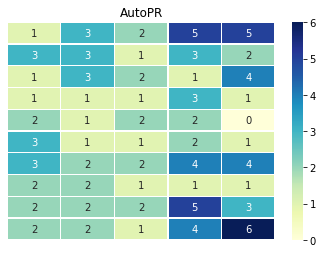

In [44]:
import seaborn as sns

def plot_conf_matrix(conf, title, xlabels, ylabels):
  sns.heatmap(conf, xticklabels=xlabels, yticklabels=ylabels, annot=True, linewidths=.3, cmap="YlGnBu").set(title=title)

labels = [dataset["dsname"] for dataset in models]
plot_conf_matrix(out, "AutoPR", [], [])